In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [2]:
results = pd.read_csv('tune_rbf_svr_fp.csv')
results.shape

(1620, 10)

In [3]:
results.columns

Index(['name', 'method', 'feature', 'nfolds', 'C', 'gamma', 'rmse', 'f1', 'f2',
       'f3'],
      dtype='object')

In [4]:
print("names {}".format(list(results['name'].value_counts().to_dict().keys())))
print("features {}".format(list(results['feature'].value_counts().to_dict().keys())))
print("nFolds {}".format(list(results['nfolds'].value_counts().to_dict().keys())))
print("C {}".format(sorted(list(results['C'].value_counts().to_dict().keys()))))
print("Gamma {}".format(sorted(list(results['gamma'].value_counts().to_dict().keys()))))

names ['MalariaNovartis', 'TB_SRI', 'ADMECaco2', 'MouseRatTox', 'TB_MDR', 'LogP', 'Xanthine-Bostaurus', 'Chagas', 'Caco2']
features ['cdk_fp', 'rdkit_fp']
nFolds [2000, 1500, 1000]
C [0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0]
Gamma [0.0001, 0.001, 0.01, 0.10000000000000001, 1.0]


In [5]:
min_summary = results.loc[results.groupby("name", as_index=False)["rmse"].idxmin()].sort_values('name')
min_summary

,name,method,feature,nfolds,C,gamma,rmse,f1,f2,f3
1208,ADMECaco2,SVR_RBF,cdk_fp,1500,100.0,0.0010,0.572875,0.529491,0.604192,0.584942
1425,Caco2,SVR_RBF,rdkit_fp,1000,1000.0,0.0001,0.597476,0.615129,0.644558,0.532740
963,Chagas,SVR_RBF,rdkit_fp,1500,100.0,0.0010,0.450124,0.411951,0.429386,0.509036
789,LogP,SVR_RBF,rdkit_fp,2000,100.0,0.0010,0.646269,0.645282,0.675833,0.617692
104,MalariaNovartis,SVR_RBF,rdkit_fp,1500,1.0,0.0100,0.532293,0.538388,0.527818,0.530673
272,MouseRatTox,SVR_RBF,cdk_fp,1000,10.0,0.0100,1.201674,1.115029,1.350355,1.139639
1531,TB_MDR,SVR_RBF,rdkit_fp,1500,10.0,0.0100,0.565720,0.559256,0.592101,0.545802
672,TB_SRI,SVR_RBF,cdk_fp,2000,1.0,0.0100,0.635401,0.626748,0.644397,0.635059
503,Xanthine-Bostaurus,SVR_RBF,rdkit_fp,2000,100.0,0.0010,0.656486,0.670693,0.721763,0.577001


In [55]:
from collections import namedtuple
from itertools import product

params = ['nfolds', 'C', 'gamma', 'feature']
Summary = namedtuple('Summary', params + ['rmse'])
param_values = [list(results[p].value_counts().to_dict().keys()) for p in params]
print("Iterating over:")
for p, values in zip(params, param_values):
    print("{}: {}".format(p, values))
combinations = product(*param_values)
best = None
for values in combinations:
    query = '&'.join([ " ({} == {}) ".format(p, "'{}'".format(v) if isinstance(v, str) else v) for p, v in zip(params, values)])
    test_df = results.query(query)
    join_df = min_summary.merge(test_df, how='inner', on='name', suffixes=('_min', '_test'))[['name', 'rmse_min', 'rmse_test']]
    rmse = math.sqrt(mean_squared_error(join_df['rmse_min'], join_df['rmse_test']))
    if best is None or best.rmse > rmse:
        summary = list(values)+[rmse]
        best = Summary(*summary)

print("Best common settings:")
for f, v in best._asdict().items():
    print("{} -> {}".format(f, v))
    
query = '&'.join([ " ({} == {}) ".format(p, "'{}'".format(v) if isinstance(v, str) else v) for p, v in zip(params, best)])
best_summary = results.query(query)[['name', 'rmse']].sort_values('name')
best_summary

Iterating over:
nfolds: [2000, 1500, 1000]
C: [0.10000000000000001, 1000.0, 0.01, 100.0, 10.0, 1.0]
gamma: [0.10000000000000001, 0.01, 0.001, 0.0001, 1.0]
feature: ['cdk_fp', 'rdkit_fp']
Best common settings:
nfolds -> 2000
C -> 10.0
gamma -> 0.001
feature -> rdkit_fp
rmse -> 0.0351027654255593


,name,rmse
1181,ADMECaco2,0.616422
1370,Caco2,0.635855
959,Chagas,0.454211
787,LogP,0.663605
159,MalariaNovartis,0.552187
296,MouseRatTox,1.254984
1579,TB_MDR,0.579276
706,TB_SRI,0.657176
473,Xanthine-Bostaurus,0.715711


In [56]:
summary = min_summary.merge(best_summary, how='inner', on='name', suffixes=('_min', '_common'))[['name', 'rmse_min', 'rmse_common']]
summary['delta'] = summary['rmse_common'] - summary['rmse_min']
summary.to_csv('tune_rbf_svr_fp_summary.csv')
summary

,name,rmse_min,rmse_common,delta
0,ADMECaco2,0.572875,0.616422,0.043548
1,Caco2,0.597476,0.635855,0.038379
2,Chagas,0.450124,0.454211,0.004086
3,LogP,0.646269,0.663605,0.017336
4,MalariaNovartis,0.532293,0.552187,0.019894
5,MouseRatTox,1.201674,1.254984,0.053310
6,TB_MDR,0.565720,0.579276,0.013556
7,TB_SRI,0.635401,0.657176,0.021775
8,Xanthine-Bostaurus,0.656486,0.715711,0.059225


In [58]:
math.sqrt(mean_squared_error(summary['rmse_min'], summary['rmse_common']))

0.0351027654255593

In [25]:
min_summary['method'] = 'SVR_RBF'
rf_results['method'] = 'RF'
summary_cat = min_summary[['name', 'rmse', 'method']].append(rf_results)

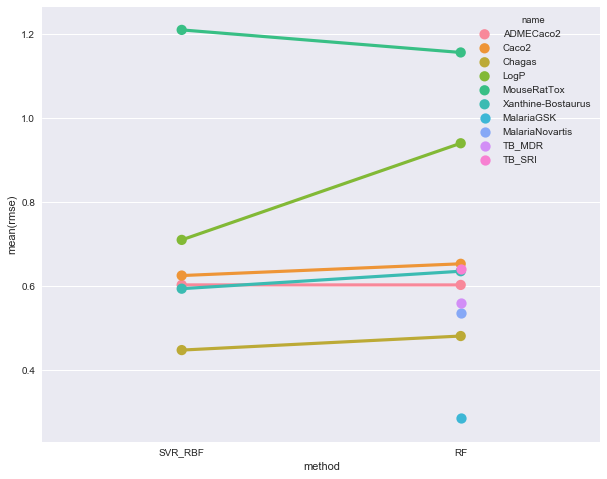

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.pointplot(x='method', y='rmse', hue='name', data=summary_cat, ax=axes)